In [1]:
# Importing necessary libraries and functions
from functions import *
import pandas as pd
from transformers import AutoImageProcessor, DinatForImageClassification

# Setting up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/media/carol/Data/Documents/Emo_rec/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda:0


In [2]:
# Constants and configurations
model_type = 'Dinat'
# model_type = 'ViT'

fourclass = True
Speaker_Disentanglement = True
Entropy = False
pretrain = True
pretraining = False
new_test = False
Cval = 4
wt_dc = 0.12
train_size = 30
eval_size = 20
column = 'label'
metric_name = "eval_uar"

In [3]:
# Paths
if pretrain:
    pathstr = r'/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV'
    processor_path = os.path.join(pathstr, 'processor')
    model_path = os.path.join(pathstr, 'model')
else:
    model_path = 'shi-labs/dinat-mini-in1k-224'
    processor_path = 'shi-labs/dinat-mini-in1k-224'

# root_path = r'/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LOSO_FOLD/MSP/MSP_003'




In [4]:
# Data Loading
dataset_train = 'cairocode/IEMO_007_NOSPLIT'
train_d0 = load_dataset(dataset_train, split='train')

dataset_val = 'cairocode/MSPI_007_NOSPLIT_an'
val_dataset0 = load_dataset(dataset_val, split='train')
val_dataset0 = val_dataset0.filter(filter_m_examples)

testds2 = 'cairocode/EMOV_003_NOSPLIT'
test_d2 = load_dataset(testds2, split='train')
test_d2= test_d2.filter(filter_m_examples)

In [5]:
dt = dataset_train[10:14]
dt1 = dataset_val[10:14]
dt2 = testds2[10:14]


base_path = os.path.join(r'/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LAST_TRY', dt)
model_prefix = f'{dt}_'

root_path = get_next_model_path(base_path, model_prefix)
print(root_path)

/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LAST_TRY/IEMO/IEMO_014


In [6]:
# Training Arguments
args = TrainingArguments(
    f"./logs2",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    disable_tqdm=True,
    learning_rate=3e-5,
    lr_scheduler_type=SchedulerType.COSINE_WITH_RESTARTS,
    warmup_ratio=0.1,
    per_device_train_batch_size=train_size,
    per_device_eval_batch_size=eval_size,
    num_train_epochs=50,
    weight_decay=wt_dc,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='./logs_DO_NOT_DELETE/3090',
    remove_unused_columns=False,
)

In [7]:
# Class Weights and Super Loss Parameters
angry_weight = 1
happy_weight = 3
neutral_weight = 3
sad_weight= 0.8

'''
Angry Weight: 1
Happy Weight: 1.6
Neutral Weight: 1.2
Sad Weight: 0.65
'''

class_weight_multipliers = {
    0: neutral_weight,
    1: happy_weight,
    2: sad_weight,
    3: angry_weight
}

In [8]:
import numpy as np
from collections import Counter
from datasets import Dataset, concatenate_datasets

def balance_dataset(dataset):
    # Assuming 'label' is the column name for your target variable
    y = np.array(dataset['label'])
    
    # Count the occurrences of each class
    class_counts = Counter(y)
    
    # Calculate the average number of samples across classes
    avg_samples = int(np.mean(list(class_counts.values())))
    
    # Initialize a list to store balanced datasets for each class
    balanced_datasets = []
    
    # Balance each class
    for label, count in class_counts.items():
        print(f"Balancing label: {label} with {count} samples")
        # Get indices of samples for this class
        indices = np.where(y == label)[0]
        if label ==0 and neutral_weight >=1:
            neu_val = int(avg_samples*1.3)
            sampled_indices = np.random.choice(indices, size=neu_val, replace=False)
        if label ==1:
            neu_val = int(avg_samples*1.3)
            sampled_indices = np.random.choice(indices, size=neu_val, replace=True)

        # Determine if undersampling or oversampling is needed
        else:
            if count > avg_samples:
                sampled_indices = np.random.choice(indices, size=avg_samples, replace=False)
            elif count < avg_samples:
                sampled_indices = np.random.choice(indices, size=avg_samples, replace=True)
            else:
                sampled_indices = indices
        
        # Select the samples and add to the list of balanced datasets
        balanced_datasets.append(dataset.select(sampled_indices))
    
    # Concatenate all balanced datasets
    return concatenate_datasets(balanced_datasets)

# Usage:
# Assuming train_dataset is your Dataset
# balanced_dataset = balance_dataset(train_dataset)

In [9]:
import io
last_row = test_d2[-1]
  
# Create a copy of the last row
new_row = dict(last_row)

# Change the label in the new row
new_row['label'] = 2

# Convert the image to bytes if it's a PIL Image
if 'image' in new_row and hasattr(new_row['image'], 'save'):
    img_byte_arr = io.BytesIO()
    new_row['image'].save(img_byte_arr, format='PNG')
    new_row['image'] = img_byte_arr.getvalue()

# Add the new row to the dataset
test_d2 = test_d2.add_item(new_row)

In [10]:
# Main Training Loop
total_results = pd.DataFrame(columns=[f'{dt}_ACC', f'{dt}_UAR', f'{dt1}_ACC', f'{dt1}_UAR', f'{dt2}_ACC', f'{dt2}_UAR'])


spkrs = [sample['speakerID'] for sample in train_d0]
unique_spkrs = list(set(spkrs))
num = int(len(unique_spkrs)/2)+1
xcorp_results = {
    'y_true': [],
    'y_pred': {f'run_{i}': [] for i in range(0, len(unique_spkrs), 2)}
}

all_y_true = defaultdict(list)
all_y_pred = defaultdict(list)


 ########################################################################################################################
                                          STARTING SPEAKER 8                                                      

 ########################################################################################################################
Balancing label: 0 with 1422 samples
Balancing label: 1 with 512 samples
Balancing label: 2 with 883 samples
Balancing label: 3 with 794 samples
Before balancing: Counter({0: 1422, 2: 883, 3: 794, 1: 512})
After balancing: Counter({1: 1172, 0: 902, 2: 902, 3: 902})


Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 3.22450110864745, 1: 2.481655290102389, 2: 0.8598669623059868, 3: 1.0748337028824835}
{'lambda': 0.11000000000000001, 'avg_loss': 1.5931283819675446, 'epoch': 0.7615384615384615}
{'eval_loss': 1.4012532234191895, 'eval_accuracy': 0.267349260523322, 'eval_uar': 0.37586121911206627, 'eval_f1': 0.19942298487679608, 'eval_top_k_acc': 0.4709897610921502, 'eval_runtime': 6.413, 'eval_samples_per_second': 137.066, 'eval_steps_per_second': 6.861, 'epoch': 1.0}
{'lambda': 0.09900000000000002, 'avg_loss': 1.3645958995819092, 'epoch': 1.5307692307692307}
{'eval_loss': 1.3327398300170898, 'eval_accuracy': 0.27986348122866894, 'eval_uar': 0.4078071451142929, 'eval_f1': 0.24856813618108797, 'eval_top_k_acc': 0.6325369738339022, 'eval_runtime': 6.261, 'eval_samples_per_second': 140.393, 'eval_steps_per_second': 7.028, 'epoch': 2.0}
{'lambda': 0.08910000000000001, 'avg_loss': 1.343597936630249, 'epoch': 2.3}
{'eval_loss': 1.1335214376449585, 'eval_accuracy': 0.4539249146757679, 'eval_uar': 0.46678

/tmp/ipykernel_406865/2464805671.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_results = pd.concat([total_results, pd.DataFrame([new_row])], ignore_index=True)


Confusion matrix saved to: /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LAST_TRY/IEMO/IEMO_014/8/results/MSPI_007_NOSPLIT_an_accuracy_42.83_UAR_44.65.png
51.01687581133708 	 40.416826824702866
{'test_loss': 1.3996118307113647, 'test_accuracy': 0.5101687581133708, 'test_uar': 0.4041682682470287, 'test_f1': 0.3578942874171216, 'test_top_k_acc': 0.7425356988316746, 'test_runtime': 16.4254, 'test_samples_per_second': 140.697, 'test_steps_per_second': 7.062}
Confusion matrix saved to: /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LAST_TRY/IEMO/IEMO_014/8/results/EMOV_003_NOSPLIT_accuracy_51.02_UAR_40.42.png

 ########################################################################################################################
                                          STARTING SPEAKER 6                                                      

 ########################################################################################################################
Balanc

Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 3.224915445321308, 1: 2.480919340849957, 2: 0.8599774520856821, 3: 1.0749718151071026}
{'lambda': 0.09000000000000001, 'avg_loss': 1.460563737154007, 'epoch': 0.7734375}
{'eval_loss': 1.3621585369110107, 'eval_accuracy': 0.2951167728237792, 'eval_uar': 0.3743484008550973, 'eval_f1': 0.273935775286162, 'eval_top_k_acc': 0.5201698513800425, 'eval_runtime': 6.563, 'eval_samples_per_second': 143.532, 'eval_steps_per_second': 7.314, 'epoch': 1.0}
{'lambda': 0.08100000000000002, 'avg_loss': 1.3863333749771118, 'epoch': 1.5546875}
{'eval_loss': 1.3100013732910156, 'eval_accuracy': 0.36942675159235666, 'eval_uar': 0.45193168176361453, 'eval_f1': 0.3484536270134395, 'eval_top_k_acc': 0.5339702760084926, 'eval_runtime': 6.5401, 'eval_samples_per_second': 144.035, 'eval_steps_per_second': 7.339, 'epoch': 2.0}
{'lambda': 0.08910000000000003, 'avg_loss': 1.317224408388138, 'epoch': 2.3359375}
{'eval_loss': 1.2875100374221802, 'eval_accuracy': 0.40764331210191085, 'eval_uar': 0.4409719657093607,

Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 3.2249999999999996, 1: 2.480769230769231, 2: 0.86, 3: 1.075}
{'lambda': 0.11000000000000001, 'avg_loss': 1.5674683392047881, 'epoch': 0.7734375}
{'eval_loss': 1.3362984657287598, 'eval_accuracy': 0.4559139784946237, 'eval_uar': 0.39545130395875927, 'eval_f1': 0.3046644372307761, 'eval_top_k_acc': 0.6021505376344086, 'eval_runtime': 6.5176, 'eval_samples_per_second': 142.69, 'eval_steps_per_second': 7.211, 'epoch': 1.0}
{'lambda': 0.12100000000000002, 'avg_loss': 1.3677869939804077, 'epoch': 1.5546875}
{'eval_loss': 1.3173621892929077, 'eval_accuracy': 0.37526881720430105, 'eval_uar': 0.43028024977376456, 'eval_f1': 0.3160215751291764, 'eval_top_k_acc': 0.5795698924731183, 'eval_runtime': 6.5163, 'eval_samples_per_second': 142.719, 'eval_steps_per_second': 7.213, 'epoch': 2.0}
{'lambda': 0.10890000000000002, 'avg_loss': 1.3136117947101593, 'epoch': 2.3359375}
{'eval_loss': 1.2199536561965942, 'eval_accuracy': 0.4290322580645161, 'eval_uar': 0.4519144367139465, 'eval_f1': 0.365592898

Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 3.2243377483443707, 1: 2.481945624468989, 2: 0.859823399558499, 3: 1.0747792494481236}
{'lambda': 0.11000000000000001, 'avg_loss': 1.478639647960663, 'epoch': 0.7615384615384615}
{'eval_loss': 1.4192548990249634, 'eval_accuracy': 0.1859122401847575, 'eval_uar': 0.2521139705882353, 'eval_f1': 0.08490685457499103, 'eval_top_k_acc': 0.40877598152424943, 'eval_runtime': 6.1181, 'eval_samples_per_second': 141.548, 'eval_steps_per_second': 7.192, 'epoch': 1.0}
{'lambda': 0.12100000000000002, 'avg_loss': 1.3899843168258668, 'epoch': 1.5307692307692307}
{'eval_loss': 1.2114185094833374, 'eval_accuracy': 0.4745958429561201, 'eval_uar': 0.44339935198496316, 'eval_f1': 0.4497385565744523, 'eval_top_k_acc': 0.7736720554272517, 'eval_runtime': 6.0974, 'eval_samples_per_second': 142.027, 'eval_steps_per_second': 7.216, 'epoch': 2.0}
{'lambda': 0.13310000000000002, 'avg_loss': 1.3271458172798156, 'epoch': 2.3}
{'eval_loss': 1.266230821609497, 'eval_accuracy': 0.41570438799076215, 'eval_uar': 0.45

Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 3.22483407079646, 1: 2.481063829787234, 2: 0.8599557522123894, 3: 1.0749446902654867}
{'lambda': 0.11000000000000001, 'avg_loss': 1.547692325115204, 'epoch': 0.7615384615384615}
{'eval_loss': 1.4584591388702393, 'eval_accuracy': 0.15693012600229095, 'eval_uar': 0.25253086419753085, 'eval_f1': 0.15168761391290708, 'eval_top_k_acc': 0.424971363115693, 'eval_runtime': 6.1434, 'eval_samples_per_second': 142.104, 'eval_steps_per_second': 7.162, 'epoch': 1.0}
{'lambda': 0.12100000000000002, 'avg_loss': 1.3673950588703156, 'epoch': 1.5307692307692307}
{'eval_loss': 1.3021012544631958, 'eval_accuracy': 0.2542955326460481, 'eval_uar': 0.3944973544973545, 'eval_f1': 0.2874707524336923, 'eval_top_k_acc': 0.5956471935853379, 'eval_runtime': 6.2426, 'eval_samples_per_second': 139.846, 'eval_steps_per_second': 7.048, 'epoch': 2.0}
{'lambda': 0.13310000000000002, 'avg_loss': 1.3413576543331147, 'epoch': 2.3}
{'eval_loss': 1.1521539688110352, 'eval_accuracy': 0.40893470790378006, 'eval_uar': 0.516

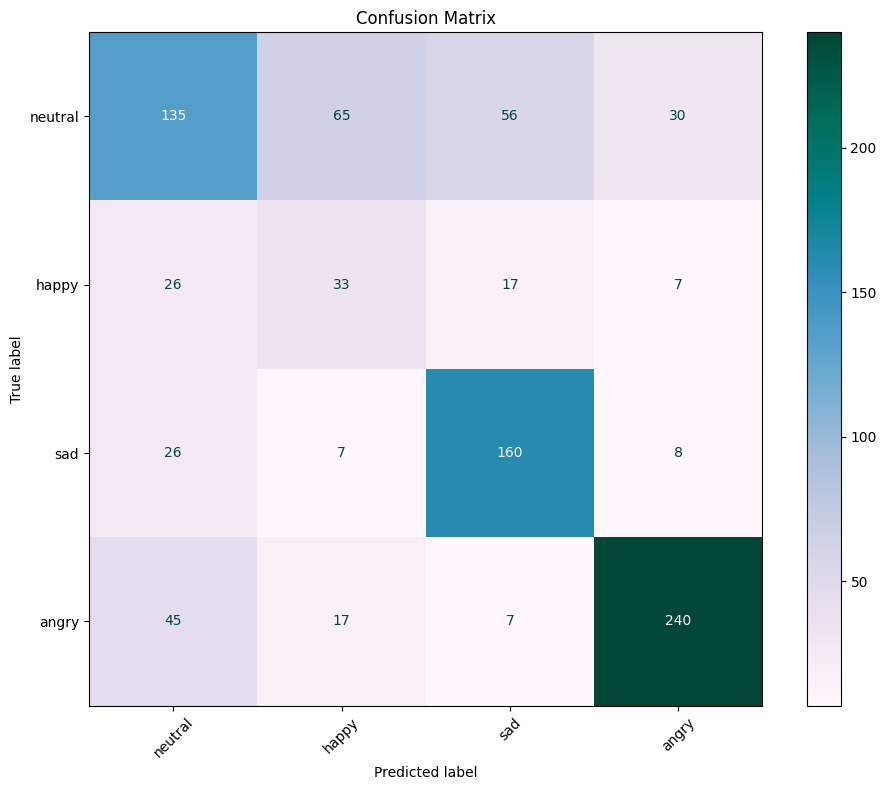

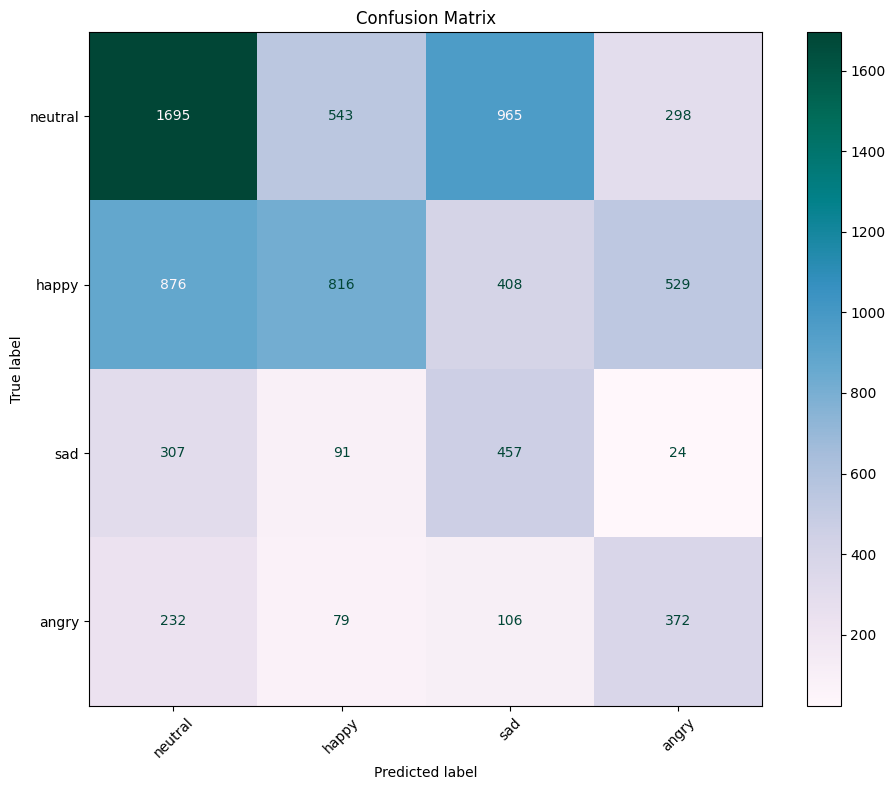

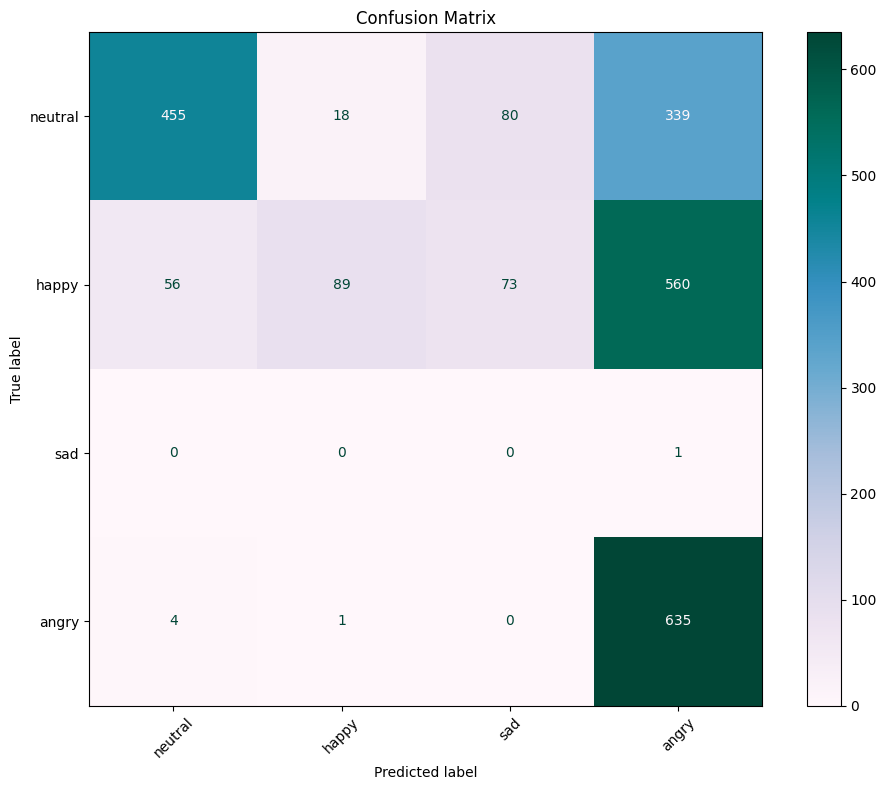

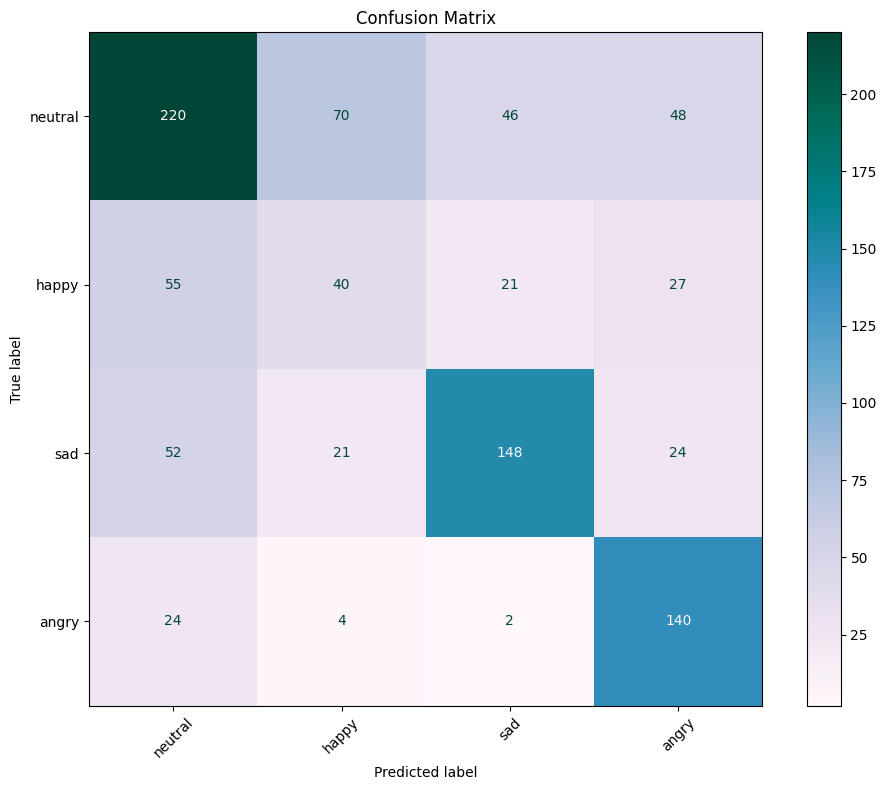

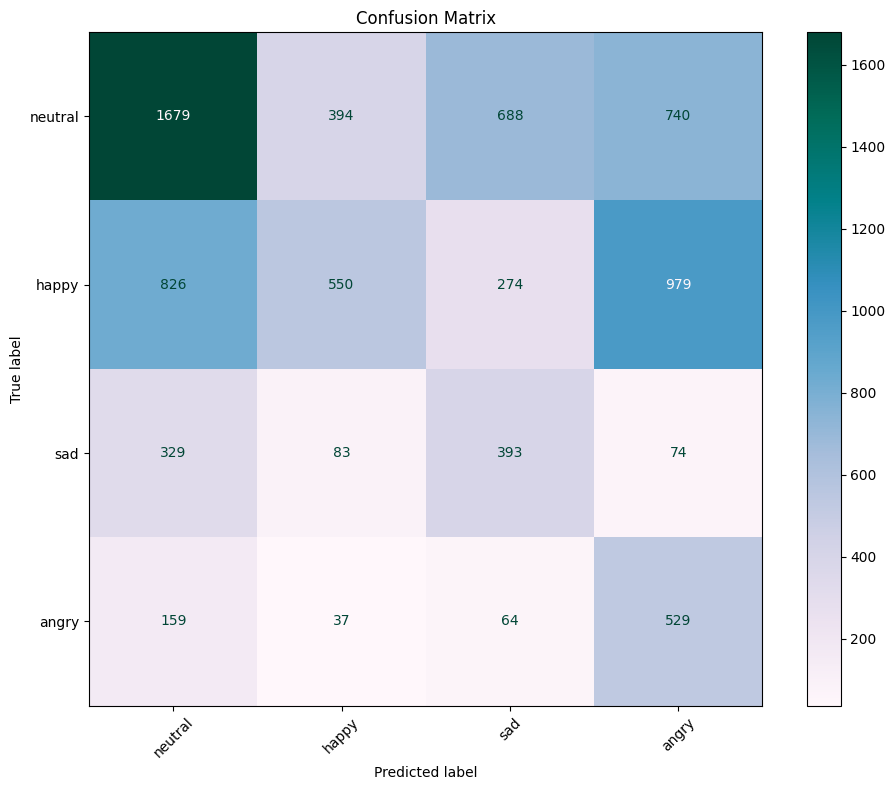

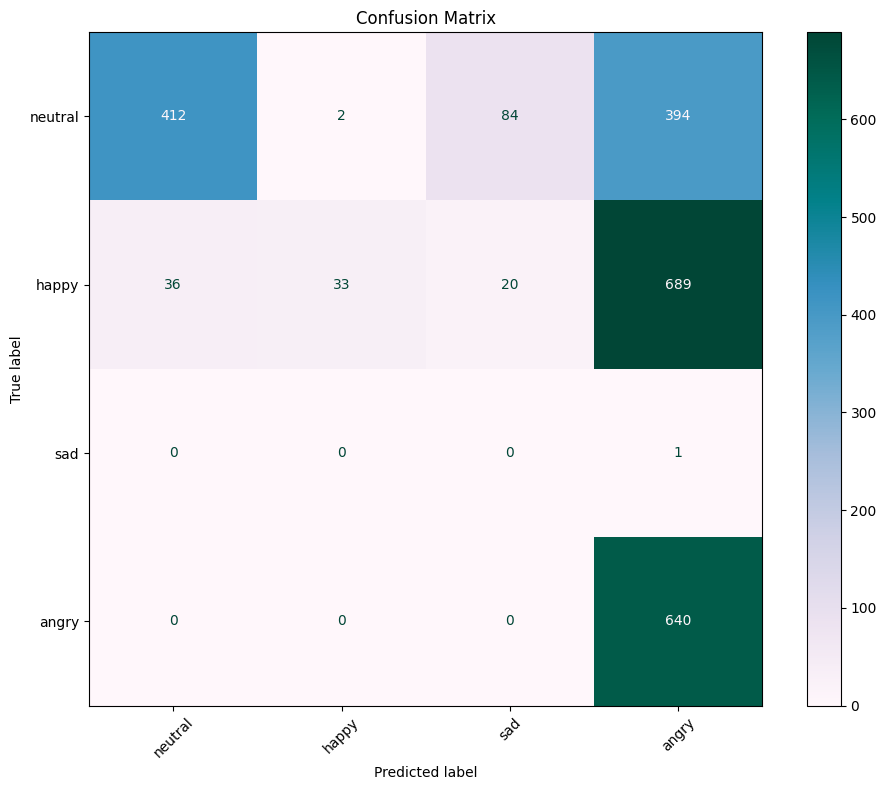

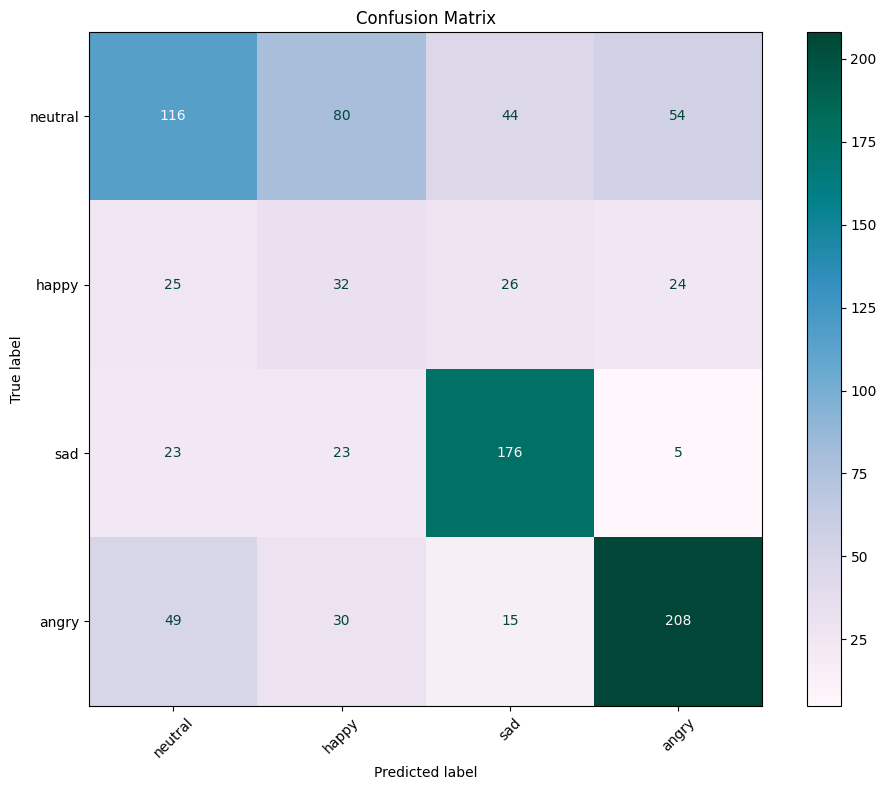

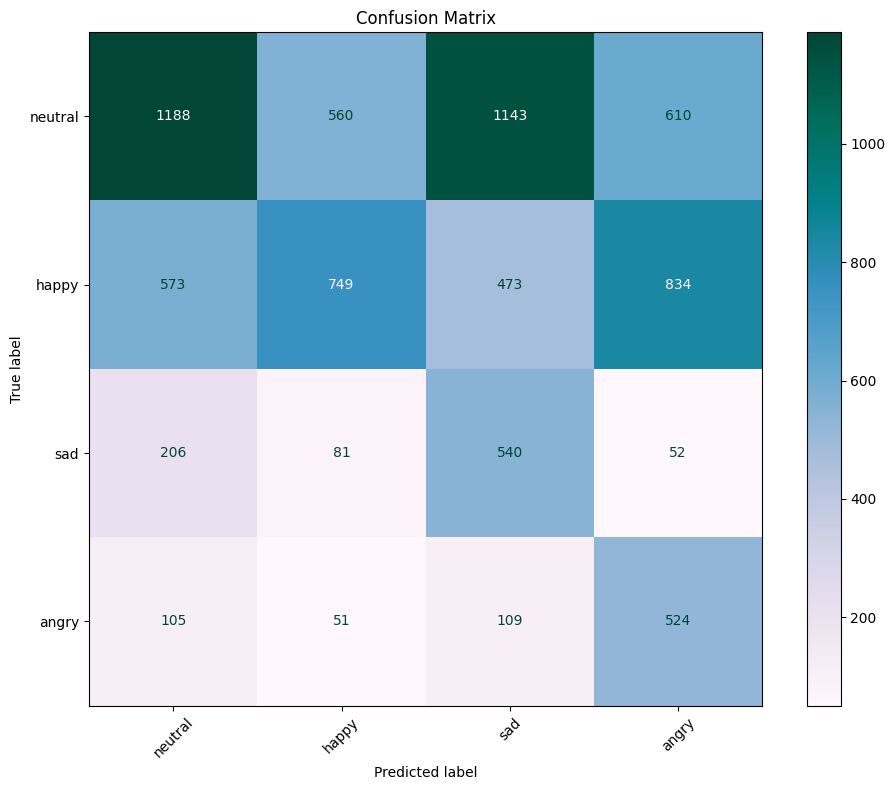

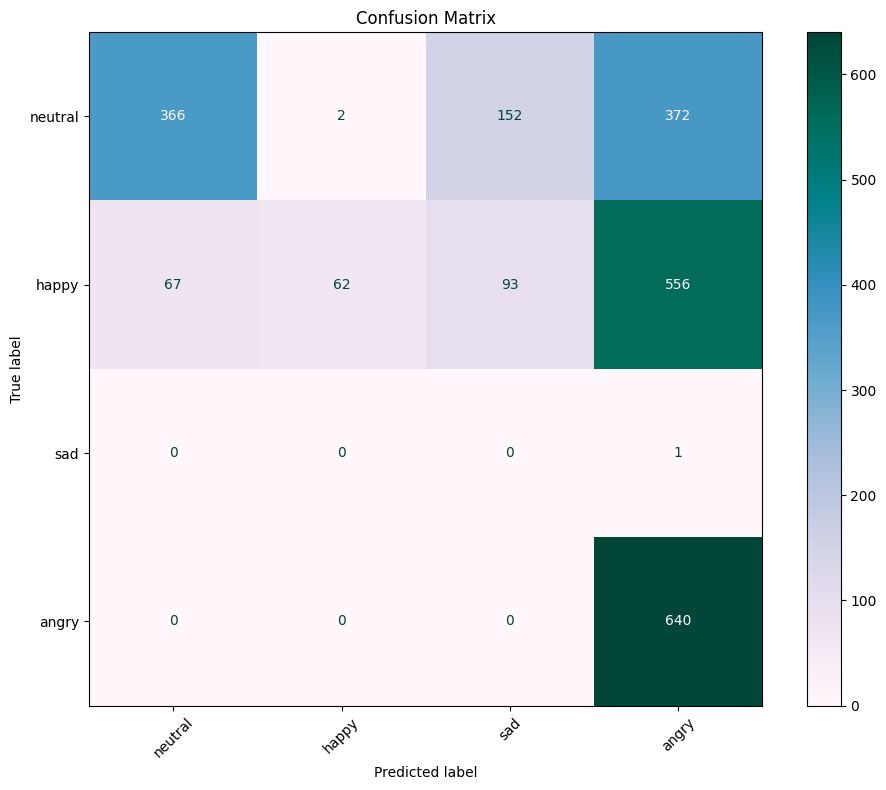

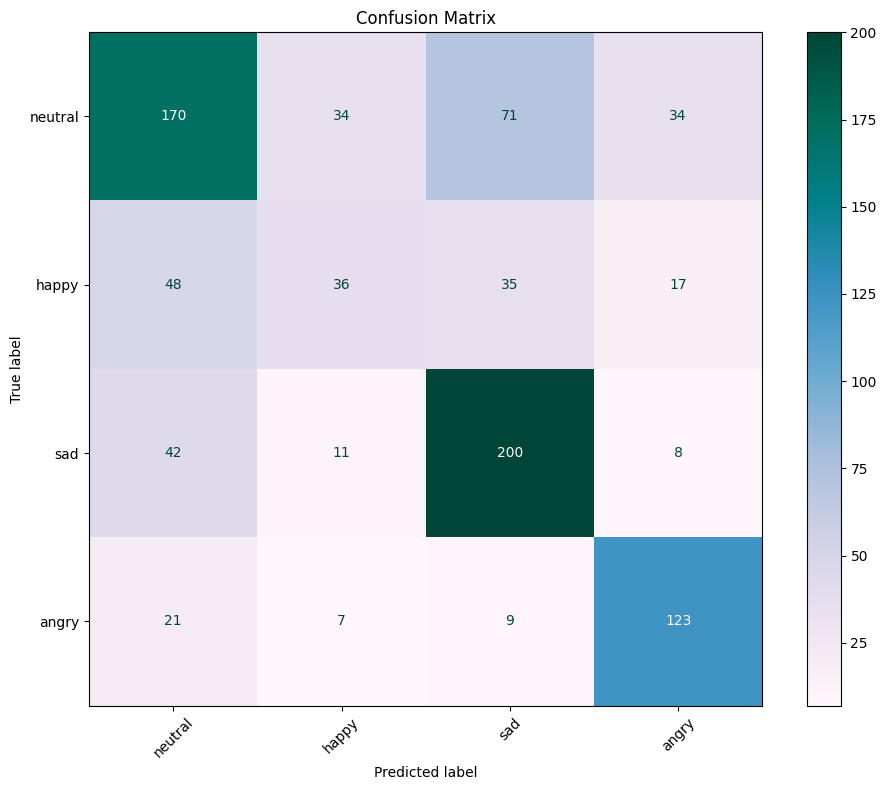

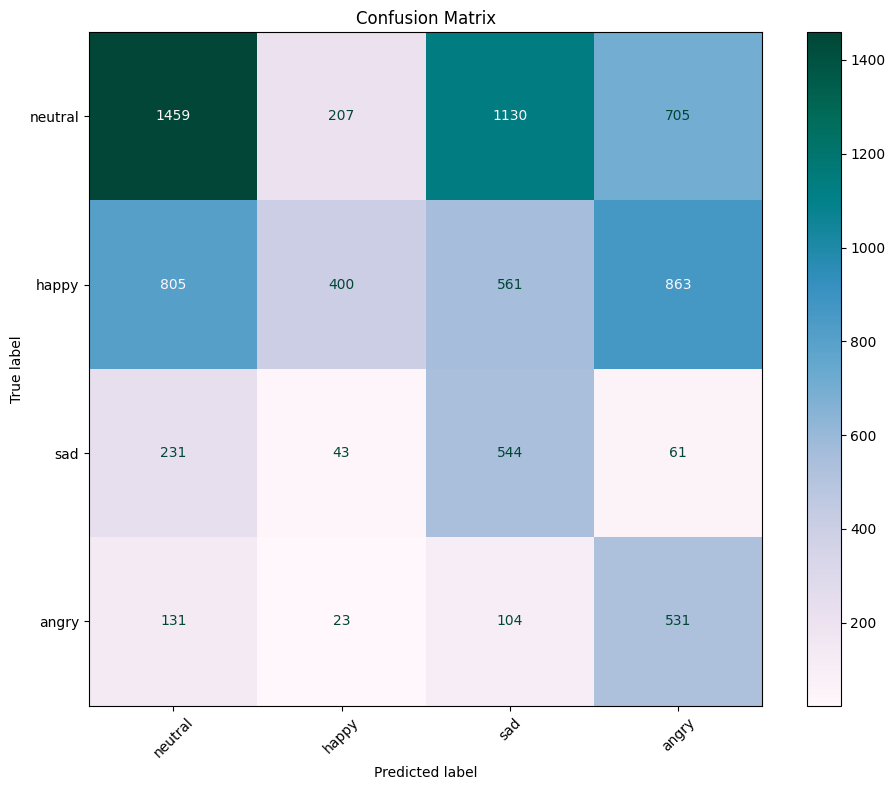

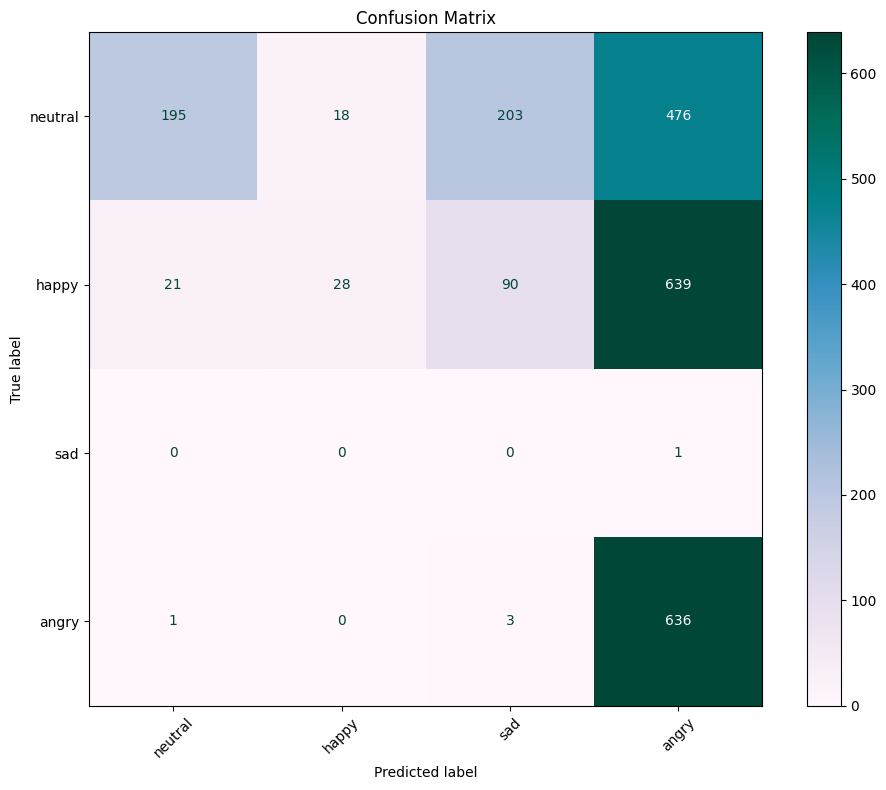

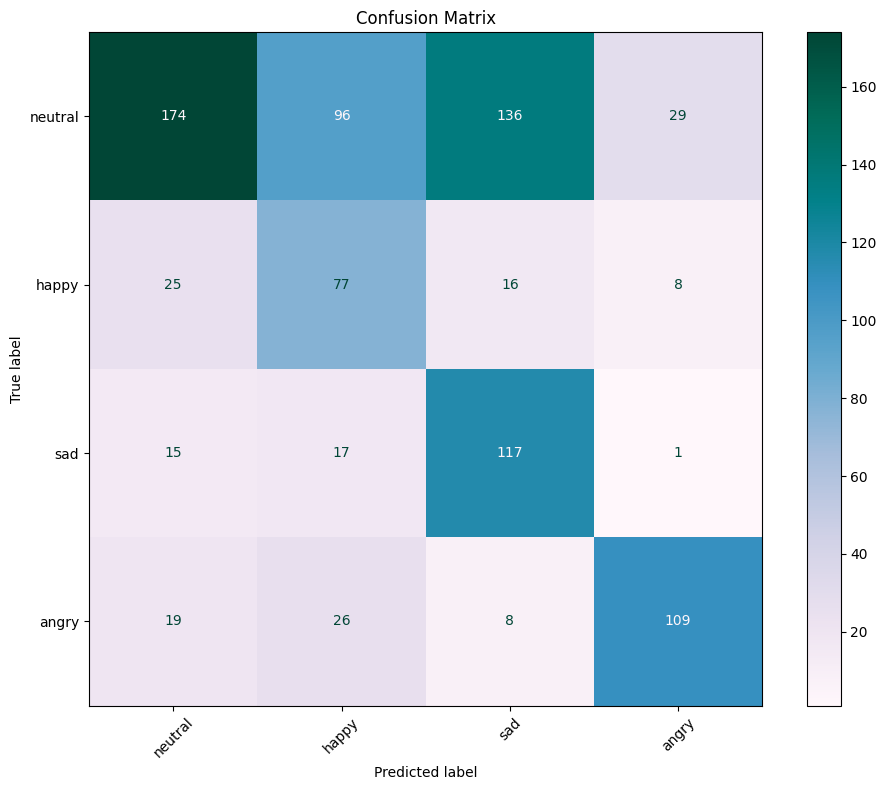

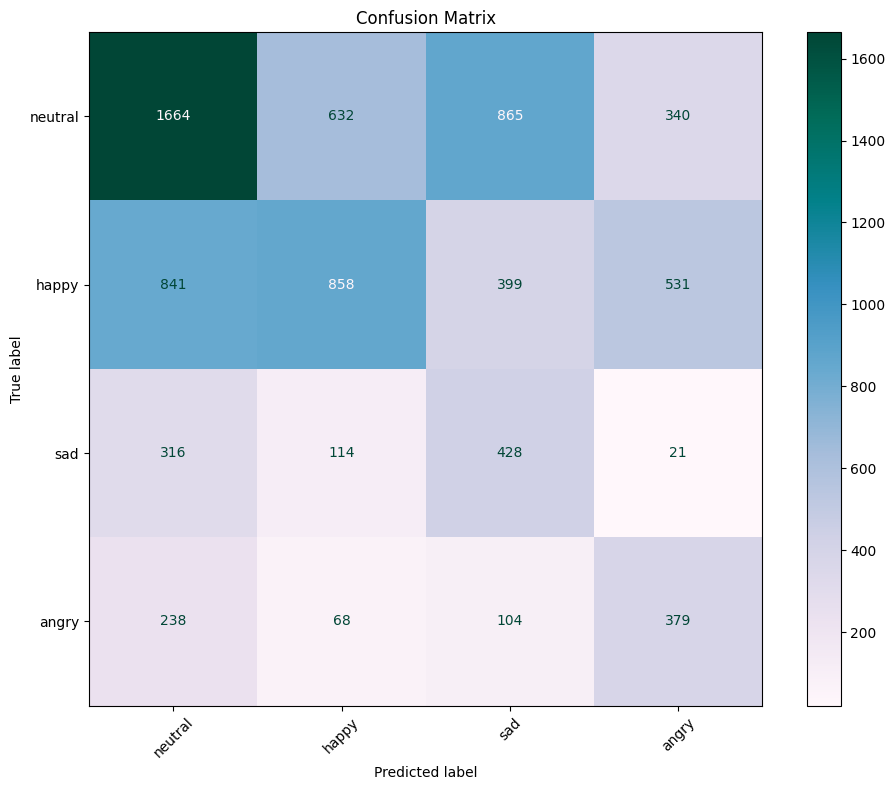

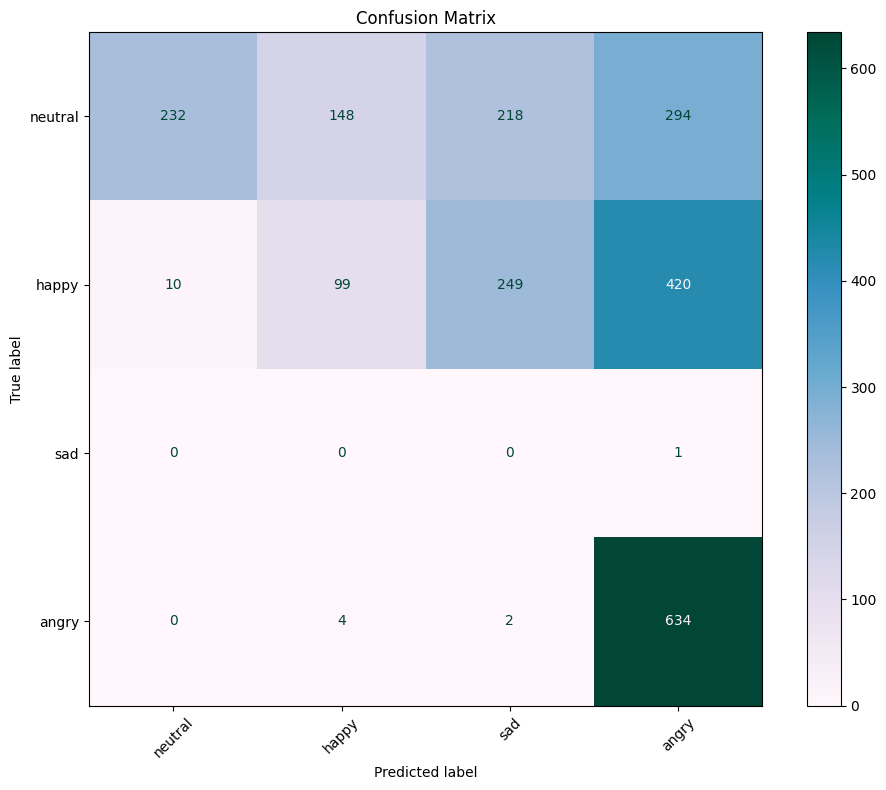

In [11]:

 

for i in range(0, len(unique_spkrs), 2):
    i = len(unique_spkrs)  -i -2
    speakers = [unique_spkrs[i], unique_spkrs[i+1]]
    print(f"\n {'#'*120}")
    print(f"                                          STARTING SPEAKER {i}                                                      ")
    print(f"\n {'#'*120}")

    new_model_path = os.path.join(root_path, str(i))
    test_dataset = train_d0.filter(lambda x: x['speakerID'] in speakers).filter(filter_m_examples)
    train_dataset = train_d0.filter(lambda x: x['speakerID'] not in speakers).filter(filter_m_examples)
    balanced_dataset = balance_dataset(train_dataset)   
    print("Before balancing:", Counter(train_dataset['label']))
    print("After balancing:", Counter(balanced_dataset['label']))

    val_dataset = concatenate_datasets([val_dataset0, test_dataset])

    processor = AutoImageProcessor.from_pretrained(processor_path)
    model = DinatForImageClassification.from_pretrained(model_path, id2label=EMOTIONS, num_labels=Cval, label2id=Map2Num, ignore_mismatched_sizes=True, problem_type='single_label_classification')

    if Speaker_Disentanglement:
        custom_dataset = CustomDataset(balanced_dataset)
        custom_sampler = CustomSampler(custom_dataset)
        train_dataloader = DataLoader(balanced_dataset, sampler=custom_sampler, collate_fn=collate_fn, batch_size=train_size)
    else:
        train_dataloader = DataLoader(balanced_dataset, collate_fn=collate_fn, batch_size=train_size)

    model.to(device)
    class_weights = calculate_class_weights(balanced_dataset, class_weight_multipliers)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    super_loss_params = {
        'C': Cval,
        'lam': 0.1,
        'batch_size': args.train_batch_size,
    }
    val_dataset.set_transform(val_transforms)
    test_dataset.set_transform(val_transforms)
    val_dataset0.set_transform(val_transforms)
    balanced_dataset.set_transform(train_transforms)
    test_d2.set_transform(test_transforms)


    early_stopping = EarlyStoppingCallback(early_stopping_patience=15, early_stopping_threshold=0.001)

    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=balanced_dataset,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        tokenizer=processor,
        callbacks=[early_stopping],
        super_loss_params=super_loss_params,
    )
    trainer.train()
    trainer.save_model(os.path.join(new_model_path, "model"))
    processor.save_pretrained(os.path.join(new_model_path, "processor"))
    test_dataset.set_transform(test_transforms)
    outputs = trainer.predict(test_dataset)
    print(outputs.metrics['test_accuracy']*100, "\t", outputs.metrics['test_uar']*100)
    print(outputs.metrics)
    model_info = {
        "Pretrain_file": pathstr,
        "Dataset Used": dataset_train,
        "Model Type": model_type,
        "Super Loss PARAMS": super_loss_params,
        "Speaker Disentanglement": Speaker_Disentanglement,
        "Entropy Curriculum Training": Entropy,
        "Column Trained on": column,
        "Test Results": outputs.metrics,
        "Test SpeakerID": speakers,
        "Angry Weight": angry_weight,
        "Happy Weight": happy_weight,
        "Neutral Weight": neutral_weight,
        "Sad Weight": sad_weight,
        "Weight decay": wt_dc
    }
    file_path = save_model_header(new_model_path, model_info)
    matrix_path = save_confusion_matrix(outputs, dataset_train, new_model_path)
    dataset_test = dataset_val
    outputs2 = trainer.predict(val_dataset0)

    new_row = {'IEMO_ACC': outputs.metrics['test_accuracy']*100, 'IEMO_UAR': outputs.metrics['test_uar']*100, 'MSP_ACC': outputs2.metrics['test_accuracy']*100,'MSP_UAR': outputs2.metrics['test_uar']*100}
    print(f"\n {'-'*120}")
    print("\n\n", new_row, "\n")
    total_results = pd.concat([total_results, pd.DataFrame([new_row])], ignore_index=True)

    if i == 0:
        xcorp_results['y_true'].extend(outputs2.label_ids)
    xcorp_results['y_pred'][f'run_{i}'].extend(outputs2.predictions.argmax(axis=1))

    matrix_path = save_confusion_matrix(outputs2, dataset_test, new_model_path)


    outputs3 = trainer.predict(test_d2)
    print(outputs3.metrics['test_accuracy']*100, "\t", outputs3.metrics['test_uar']*100)
    print(outputs3.metrics)
    matrix_path = save_confusion_matrix(outputs3, testds2, new_model_path)

    all_y_true[dt].extend(outputs.label_ids)
    all_y_pred[dt].extend(outputs.predictions.argmax(axis=1))
    all_y_true[dt1].extend(outputs2.label_ids)
    all_y_pred[dt1].extend(outputs2.predictions.argmax(axis=1))
    all_y_true[dt2].extend(outputs3.label_ids)
    all_y_pred[dt2].extend(outputs3.predictions.argmax(axis=1))

    torch.cuda.empty_cache()
    del trainer
    del model

In [12]:
len(unique_spkrs) 

10

In [13]:
# Final Results and Metrics
y_true = np.array(xcorp_results['y_true'])
final_prediction = np.array([np.bincount([xcorp_results['y_pred'][f'run_{i}'][j] for i in range(0, len(unique_spkrs), 2)]).argmax() 
                             for j
                              in range(len(y_true))])

final_accuracy = accuracy_score(y_true, final_prediction)
print(f"Final accuracy after majority voting: {final_accuracy}")
print(total_results)
avg_results = total_results.mean(numeric_only=True)

print("\nAVERAGE RESULTS\n", avg_results)

final_metrics = {}
for dataset in [dt, dt1, dt2]:
    y_true = np.array(all_y_true[dataset])
    y_pred = np.array(all_y_pred[dataset])

    acc = accuracy_score(y_true, y_pred) * 100
    uar = balanced_accuracy_score(y_true, y_pred) * 100

    final_metrics[f'{dataset}_ACC'] = acc
    final_metrics[f'{dataset}_UAR'] = uar

print("\nFinal Metrics:")
print(final_metrics)
# Save Final Results
model_info = {
    "Pretrain_file": pathstr,
    "Dataset Used": dataset_train,
    "Model Type": model_type,
    "Super Loss PARAMS": super_loss_params,
    "Speaker Disentanglement": Speaker_Disentanglement,
    "Entropy Curriculum Training": Entropy,
    "Column Trained on": column,
    "Test SpeakerID": speakers,
    "Angry Weight": angry_weight,
    "Happy Weight": happy_weight,
    "Neutral Weight": neutral_weight,
    "Sad Weight": sad_weight,
    "Weight decay": wt_dc, 
    "Avg Results": avg_results.to_dict(), 
    "total results": final_metrics
}
file_path = save_model_header(root_path, model_info)

Final accuracy after majority voting: 0.42062067196717107
    IEMO_ACC   IEMO_UAR MSPI_ACC MSPI_UAR EMOV_ACC EMOV_UAR    MSP_ACC  \
0  64.618885  61.058432      NaN      NaN      NaN      NaN  42.831495   
1  58.174098  57.006200      NaN      NaN      NaN      NaN  40.407797   
2  57.204301  53.942384      NaN      NaN      NaN      NaN  38.484227   
3  61.085450  58.747530      NaN      NaN      NaN      NaN  37.625032   
4  54.639175  61.598765      NaN      NaN      NaN      NaN  42.690433   

     MSP_UAR  
0  44.648086  
1  45.158755  
2  47.567428  
3  46.519402  
4  44.223111  

AVERAGE RESULTS
 IEMO_ACC    59.144382
IEMO_UAR    58.470662
MSP_ACC     40.407797
MSP_UAR     45.623356
dtype: float64

Final Metrics:
{'IEMO_ACC': 59.10913140311804, 'IEMO_UAR': 58.14774343732735, 'MSPI_ACC': 40.40779687099256, 'MSPI_UAR': 45.623356348945855, 'EMOV_ACC': 44.621376027693636, 'EMOV_UAR': 36.1864598883823}
File saved successfully at: /media/carol/Data/Documents/Emo_rec/Trained Models/DIN

In [14]:
num

6